In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [34]:
DF = pd.read_excel('PQM dataset.xlsx', sheet_name='Frequency_1Min')
print("DataFrame shape:", DF.shape)

DataFrame shape: (360300, 7)


In [35]:
# calculating z-scores for outlier detection
def calc_zscore(column):
    mean = np.mean(column)
    std_dev = np.std(column)

    if std_dev == 0:
        return np.zeros_like(column)
    
    z_scores = (column - mean) / std_dev
    return z_scores

In [36]:
columns = [col for col in DF.columns if col not in ['TimeID']]

z_scores = DF[columns].apply(calc_zscore)

print(z_scores.head())

      Col_1     Col_2     Col_3     Col_4     Col_5     Col_6
0  0.000369  0.321860 -0.314273  0.239708 -0.220456  0.011591
1  0.000454  0.321860 -0.314187  0.239708 -0.220370  0.011676
2 -0.000232  0.320937 -0.314187  0.238787 -0.220370  0.010993
3  0.000454  0.321776 -0.314101  0.239624 -0.220285  0.011676
4  0.000626  0.321776 -0.313843  0.239624 -0.220029  0.011847


In [37]:
# cleaning data by removing outliers and filling NaN values
outlier_mask = (np.abs(z_scores) > 3).any(axis=1)
print(f"Found {outlier_mask.sum()} outliers in the dataset")

cleanDF = DF[~outlier_mask]
print("Cleaned DataFrame shape:", cleanDF.shape)
cleanDF = cleanDF.dropna()
print("Cleaned DataFrame shape after dropping NaNs:", cleanDF.shape)

Found 721 outliers in the dataset
Cleaned DataFrame shape: (359579, 7)
Cleaned DataFrame shape after dropping NaNs: (308870, 7)


In [38]:
# window size = 6 for 12 columns
input_size = 3
power_columns = [col for col in cleanDF.columns if col != 'TimeID']

x_list = []
y_list = []

In [39]:
for i in range(len(power_columns) - input_size):
    input_window = power_columns[i:i + input_size]
    target_column = power_columns[i + input_size]

    x_list.append(cleanDF[input_window].values)
    y_list.append(cleanDF[target_column].values)

In [40]:
x = np.vstack(x_list)
y = np.hstack(y_list)

print("Input shape:", x.shape)
print("Target shape:", y.shape)

Input shape: (926610, 3)
Target shape: (926610,)


In [41]:
split_index = int(0.8 * len(x))

x_train = x[:split_index]
y_train = y[:split_index]

x_test = x[split_index:]
y_test = y[split_index:]

print("Training set shape:", x_train.shape, y_train.shape)
print("Test set shape:", x_test.shape, y_test.shape)

Training set shape: (741288, 3) (741288,)
Test set shape: (185322, 3) (185322,)


In [42]:
model = LinearRegression()
model.fit(x_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [43]:
# test train split
y_pred = model.predict(x_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Model Performance on Test Set:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R-squared (R2): {r2:.4f}")

Model Performance on Test Set:
Mean Absolute Error (MAE): 0.0098
Mean Squared Error (MSE): 0.0003
R-squared (R2): 0.9806


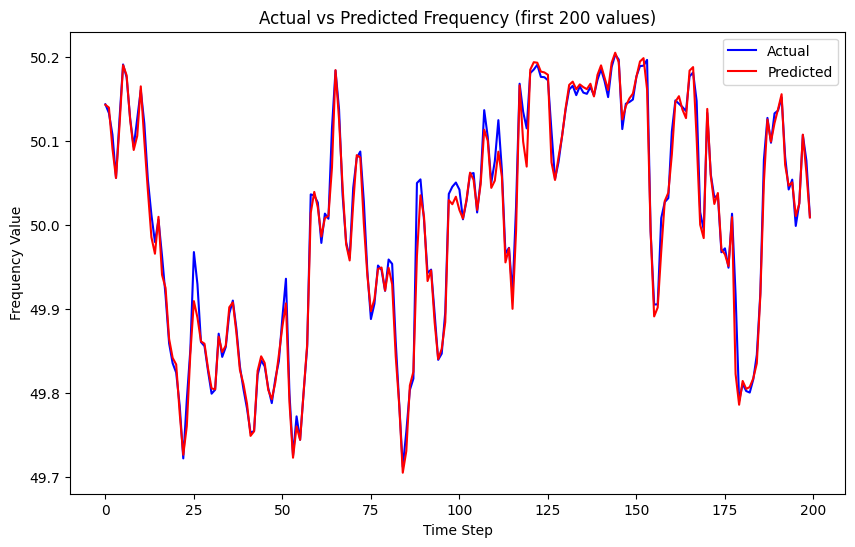

In [44]:
plt.figure(figsize=(10, 6))
plt.plot(y_test[:200], label='Actual', color='blue')
plt.plot(y_pred[:200], label='Predicted', color='red')
plt.title('Actual vs Predicted Frequency (first 200 values)')
plt.xlabel('Time Step')
plt.ylabel('Frequency Value')
plt.legend()
plt.show()

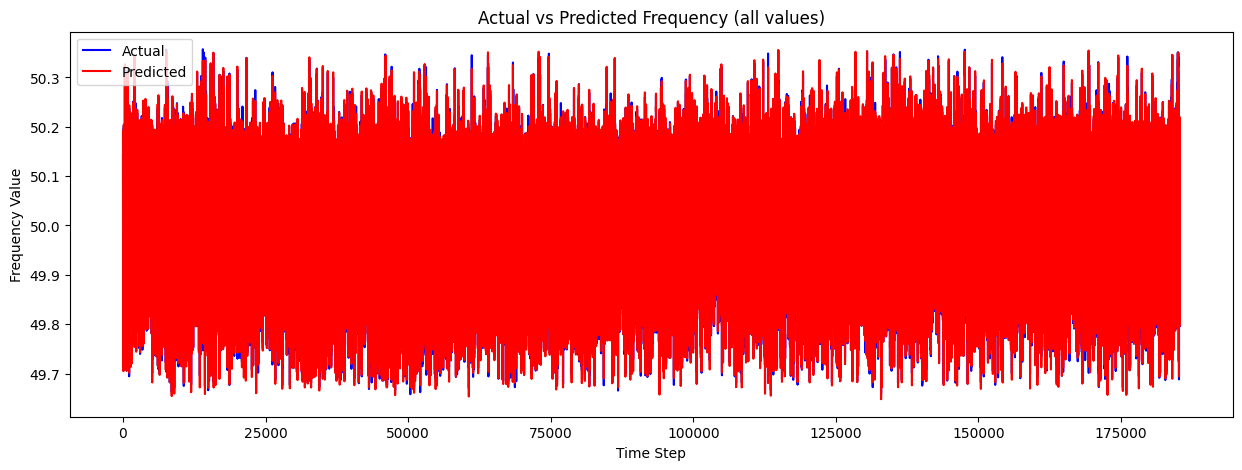

In [45]:
plt.figure(figsize=(15, 5))
plt.plot(y_test, label='Actual', color='blue')
plt.plot(y_pred, label='Predicted', color='red')
plt.title('Actual vs Predicted Frequency (all values)')
plt.xlabel('Time Step')
plt.ylabel('Frequency Value')
plt.legend()
plt.show()